In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

from functools import partial
from rejax import get_algo
from rejax.evaluate import evaluate, EvalState
from tqdm.notebook import tqdm

import _pickle as pickle
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import yaml


In [2]:
env_name = "lqr"
algo_name = "ppo"
data_dir = f"/home/bryanpu1/projects/aaai_2026/data/{env_name}"

os.makedirs(data_dir, exist_ok=True)

In [ ]:
config_path = "./configs/custom/{}.yaml".format(env_name)

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

config = config[algo_name]
num_seeds = 1000

num_files = 5
starting_seed_id = 0

max_steps_in_episode = 200

if env_name == "cartpole":
    from gymnax.environments.classic_control.cartpole import EnvParams, CartPole
    env = CartPole()

    def sample_env_params(key):
        return {
            "gravity": jax.random.uniform(key, shape=(num_seeds,)) * 10.0
        }

    def apply_env_params(algo_cls, env_params):
        return algo_cls.create(
            **config,
            env_params=EnvParams(
                gravity=env_params["gravity"],
                max_steps_in_episode=max_steps_in_episode,
            ),
        )

elif env_name.startswith("lqr"):
    # XXX: LQR can have unbounded state (and actions depending on policy parameterization)
    env_setting = dict(
        dim_x=3,
        dim_u=3,
        x_thres=1e-2,
        sigma_w=0.0,
        std_x=1.0,
    )

    kv_pairs = env_name.split("-")[1:]
    for kv_pair in kv_pairs:
        (key, val) = kv_pair.split("=")

        if key in ["dim_u", "dim_x"]:
            env_setting[key] = int(val)
        elif key in ["x_thres", "sigma_w", "std_x"]:
            env_setting[key] = float(val)

    from rejax.envs.lqr import (
        EnvParams,
        DiscreteTimeLQR,
        is_controllable,
        is_stable,
    )

    dim_x, dim_u = env_setting["dim_x"], env_setting["dim_u"]
    x_thres = env_setting["x_thres"]
    sigma_w = env_setting["sigma_w"]
    std_x = env_setting["std_x"]
    env = DiscreteTimeLQR(dim_x, dim_u)

    def sample_env_params(key):
        env_params = {
            "A": [],
            "B": [],
        }
        for seed_i in range(num_seeds):
            key = jax.random.fold_in(key, seed_i)
            env_params["A"].append(jnp.zeros((dim_x, dim_x)))
            env_params["B"].append(jnp.zeros((dim_u, dim_u)))
            
            env_key = key
            while not is_controllable(
                env_params["A"][-1],
                env_params["B"][-1],
            ) or not is_stable(
                env_params["A"][-1],
                env_params["B"][-1],
            ) or np.any(np.sum(env_params["A"][-1], axis=-1) > 1)  or np.any(np.sum(env_params["B"][-1], axis=-1) > 1):
                env_key, _ = jax.random.split(env_key)
                env_params["A"][-1] = jnp.tanh(jax.random.normal(
                    jax.random.fold_in(env_key, 0),
                    shape=(dim_x, dim_x),
                ))
                env_params["B"][-1] = jnp.tanh(jax.random.normal(
                    jax.random.fold_in(env_key, 1),
                    shape=(dim_u, dim_u),
                ))
        return {
            **{k: jnp.stack(v) for k, v in env_params.items()},
            "Q": jnp.concatenate([jnp.diag(
                1.0 - jax.random.uniform(
                    jax.random.fold_in(jax.random.fold_in(key, 2), seed),
                    shape=(dim_x),
                )
            )[None] for seed in range(num_seeds)], axis=0),
            "R": jnp.concatenate([jnp.diag(
                1.0 - jax.random.uniform(
                    jax.random.fold_in(jax.random.fold_in(key, 3), seed),
                    shape=(dim_u),
                )
            )[None] for seed in range(num_seeds)], axis=0),
        }

    def apply_env_params(algo_cls, env_params):
        return algo_cls.create(
            **config,
            env_params=EnvParams(
                x_thres=x_thres,
                max_steps_in_episode=max_steps_in_episode,
                sigma_w=sigma_w,
                std_x=std_x,
                A=env_params["A"],
                B=env_params["B"],
                Q=env_params["Q"],
                R=env_params["R"],
            ),
        )
    
    from scipy.linalg import solve_discrete_are
    def get_opt_controllers(env_params):
        opt_controllers = []
        for (A, B, Q, R) in zip(
            env_params["A"],
            env_params["B"],
            env_params["Q"],
            env_params["R"],
        ):
            opt_cost = solve_discrete_are(A, B, Q, R)

            opt_controller = -np.linalg.pinv(
                R + B.T @ opt_cost @ B @ B.T @ opt_cost @ A
            )
            opt_controllers.append(opt_controller[None])
        return np.concatenate(
            opt_controllers, axis=0
        )

else:
    raise NotImplementedError

config["env"] = env

In [4]:
config

{'agent_kwargs': {'activation': 'tanh'},
 'num_envs': 1,
 'num_steps': 100,
 'num_epochs': 5,
 'num_minibatches': 5,
 'learning_rate': 0.0003,
 'max_grad_norm': 0.5,
 'total_timesteps': 100000,
 'eval_freq': 5000,
 'gamma': 0.95,
 'gae_lambda': 0.95,
 'clip_eps': 0.2,
 'ent_coef': 0.01,
 'vf_coef': 0.5,
 'buffer_size': 100000,
 'env': <rejax.envs.lqr.DiscreteTimeLQR at 0x79ef12de9b10>}

In [5]:
for file_i in tqdm(range(num_files)):
    seed_id = starting_seed_id + file_i

    key = jax.random.PRNGKey(seed_id)
    keys = jax.random.split(key, num_seeds)

    env_params = sample_env_params(key)

    algo_cls = get_algo(algo_name)
    algo = jax.vmap(
        apply_env_params,
        in_axes=(None, 0),
    )(
        algo_cls,
        env_params,
    )

    def eval_callback(algo, ts, rng):
        act = algo.make_act(ts)
        return evaluate(act, rng, env, algo.env_params, 50, max_steps_in_episode)

    def get_returns(algo, ts, rng):
        eval_info = eval_callback(algo, ts, rng)
        return eval_info.length, eval_info.return_

    algo = algo.replace(
        eval_callback=get_returns
    )

    # Train
    vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
    ts, (_, returns) = vmap_train(algo, keys)
    returns.block_until_ready()

    # Get expert actions
    def get_expert_actions(ts, num_steps):
        act = algo.make_act(ts)
        def step(step_i: int, state: EvalState):
            rng, rng_act, rng_step = jax.random.split(state.rng, 3)
            action = act(state.trajectory["obss"][step_i], rng_act)

            state = EvalState(
                rng,
                None,
                None,
                trajectory=dict(
                    obss=state.trajectory["obss"],
                    actions=state.trajectory["actions"].at[step_i].set(action),
                ),
            )
            return state

        state = EvalState(
            key,
            None,
            None,
            trajectory=dict(
                obss=ts.store_buffer.data.obs if hasattr(ts, "store_buffer") else ts.replay_buffer.data.obs,
                actions=ts.store_buffer.data.action if hasattr(ts, "store_buffer") else ts.replay_buffer.data.action,
            )
        )
        state = jax.lax.fori_loop(
            0,
            num_steps,
            step,
            state,
        )
        return state.trajectory["actions"]

    expert_actions = jax.vmap(
        jax.jit(get_expert_actions, static_argnames=["num_steps"]),
        in_axes=[0, None],
    )(
        ts,
        ts.store_buffer.data.action.shape[1]  if hasattr(ts, "store_buffer") else ts.replay_buffer.data.action.shape[1],
    )

    # "Expert data" from last PPO iteration
    expert_trajectories = jax.vmap(eval_callback)(algo, ts, keys)

    # Save data
    pickle.dump(
        {
            "buffer_info": {k: v for k, v in (ts.store_buffer.__dict__.items() if hasattr(ts, "store_buffer") else ts.replay_buffer.__dict__.items()) if k != "data"},
            "learning_histories": {
                "expert_action": np.array(expert_actions),
                **{k: np.array(v) for k, v in (ts.store_buffer.data._asdict().items() if hasattr(ts, "store_buffer") else ts.replay_buffer.data._asdict().items())}
            },
            "algorithm": {
                "algo": algo_name,
                **{k: v for k, v in config.items() if k != "env"},
            },
            "env": type(config["env"]).__name__,
            "env_params": {k: np.array(v) for k, v in env_params.items()},
            "observation_space": env.observation_space(EnvParams()),
            "action_space": env.action_space(EnvParams()),
            "expert_data": {
                k: np.array(v) for k, v in expert_trajectories.trajectory.items()
            },
        },
        open("{}/learning_hist-{}-horizon={}-num_tasks={}-seed={}-{}.pkl".format(
            data_dir,
            env_name,
            max_steps_in_episode,
            num_seeds,
            seed_id,
            algo_name,
        ), "wb"),
    )


  0%|          | 0/1 [00:00<?, ?it/s]

2025-07-13 12:40:23.491379: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-13 12:40:23.491458: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-13 12:40:23.491500: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [6]:
if num_seeds > 10:
    assert 0

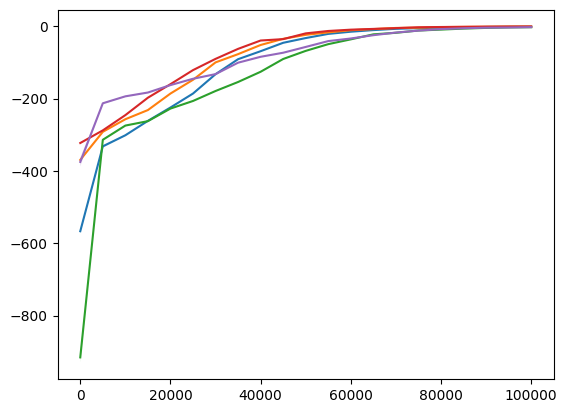

In [7]:
for env_returns in returns[:]:
    xrange = np.arange(len(env_returns)) * config["eval_freq"]
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1) / np.sqrt(env_returns.shape[-1])
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()
